In [39]:
import numpy as np
import pandas as pd
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

In [40]:
data_path = r'C:\Users\yeswa\OneDrive\Desktop\time_series\data\Amazon_sales\amazon_sales_report.csv'

In [41]:
# Set random seed
np.random.seed(42)

In [42]:

# Using double backslashes
df_sales = pd.read_csv(data_path, low_memory=False)
df_sales.head(2)

,index,Order ID,Date,Status,Fulfilment,Sales Channel,ship-service-level,Style,SKU,Category,...,currency,Amount,ship-city,ship-state,ship-postal-code,ship-country,promotion-ids,B2B,fulfilled-by,Unnamed: 22
0,0,405-8078784-5731545,04-30-22,Cancelled,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,...,INR,647.62,MUMBAI,MAHARASHTRA,400081.0,IN,NaN,False,Easy Ship,NaN
1,1,171-9198151-1101146,04-30-22,Shipped - Delivered to Buyer,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,...,INR,406.00,BENGALURU,KARNATAKA,560085.0,IN,Amazon PLCC Free-Financing Universal Merchant ...,False,Easy Ship,NaN


#### EDA

In [43]:
df_sales.shape

(128975, 24)

In [44]:
# Assuming df is your DataFrame
unique_counts = df_sales.nunique()
data_types = df_sales.dtypes

# Convert the result to a DataFrame
unique_counts_df = pd.DataFrame({'Unique Values Count': unique_counts, 'Data Type': data_types})

# Sort the DataFrame based on unique values count
sorted_counts_df = unique_counts_df.sort_values(by='Unique Values Count', ascending=False)

sorted_counts_df

,Unique Values Count,Data Type
index,128975,int64
Order ID,120378,object
ship-postal-code,9459,float64
ship-city,8955,object
SKU,7195,object
ASIN,7190,object
promotion-ids,5787,object
Amount,1410,float64
Style,1377,object
Date,91,object


In [45]:
# Select columns you want to separate
selected_columns = ['Date', 'Status', 'Fulfilment', 'Category', 'Qty', 'Size', 'Amount']

# Create a new DataFrame with selected columns
selected_df = df_sales[selected_columns]

selected_df.head()

,Date,Status,Fulfilment,Category,Qty,Size,Amount
0,04-30-22,Cancelled,Merchant,Set,0,S,647.62
1,04-30-22,Shipped - Delivered to Buyer,Merchant,kurta,1,3XL,406.00
2,04-30-22,Shipped,Amazon,kurta,1,XL,329.00
3,04-30-22,Cancelled,Merchant,Western Dress,0,L,753.33
4,04-30-22,Shipped,Amazon,Top,1,3XL,574.00


In [46]:
# Drop rows where the value in the 'Status' column is equal to 'Cancelled'
df_filtered = selected_df[selected_df['Status'] != 'Cancelled']
df_filtered.head(2)

,Date,Status,Fulfilment,Category,Qty,Size,Amount
1,04-30-22,Shipped - Delivered to Buyer,Merchant,kurta,1,3XL,406.0
2,04-30-22,Shipped,Amazon,kurta,1,XL,329.0


In [47]:
# Get a list of unique values from the 'Status' column
unique_status_values = df_sales['Status'].unique()
unique_status_values

array(['Cancelled', 'Shipped - Delivered to Buyer', 'Shipped',
       'Shipped - Returned to Seller', 'Shipped - Rejected by Buyer',
       'Shipped - Lost in Transit', 'Shipped - Out for Delivery',
       'Shipped - Returning to Seller', 'Shipped - Picked Up', 'Pending',
       'Pending - Waiting for Pick Up', 'Shipped - Damaged', 'Shipping'],
      dtype=object)

In [48]:
# Filter DataFrame based on column value equal to 'Cancelled'
cancelled_orders = df_sales[df_sales['Status'] == 'Cancelled']
cancelled_orders.shape

(18332, 24)

In [49]:
# Filter the DataFrame where qty column is 0 and get unique values of status column
unique_statuses_with_qty_zero = df_sales.loc[df_sales['Qty'] == 0, 'Status'].unique().tolist()
unique_statuses_with_qty_zero

['Cancelled',
 'Shipped',
 'Shipped - Delivered to Buyer',
 'Pending',
 'Shipped - Returned to Seller']

In [50]:
# Drop rows where the value in the 'Status' column is equal to 'Cancelled'
df_final = selected_df[(selected_df['Status'] != 'Cancelled') & (selected_df['Qty'] != 0)]
df_final.head(2)

,Date,Status,Fulfilment,Category,Qty,Size,Amount
1,04-30-22,Shipped - Delivered to Buyer,Merchant,kurta,1,3XL,406.0
2,04-30-22,Shipped,Amazon,kurta,1,XL,329.0


In [51]:
# Group by 'Qty' column and count number of rows in each group
grouped = df_final.groupby('Qty').size()
grouped

Qty
1     110175
2        315
3         32
4          9
5          2
8          1
9          1
13         1
15         1
dtype: int64

In [52]:
select_qty = df_final[df_final['Qty'] == 15]
select_qty

,Date,Status,Fulfilment,Category,Qty,Size,Amount
937,04-30-22,Shipped,Amazon,Blouse,15,Free,NaN


In [53]:
# Group by 'Qty' column and count number of rows in each group
grouped = df_final.groupby('Fulfilment').size()
grouped

Fulfilment
Amazon      78132
Merchant    32405
dtype: int64

In [54]:
select_fulfilment = df_final[df_final['Fulfilment'] == 'Amazon']
select_fulfilment.head()

,Date,Status,Fulfilment,Category,Qty,Size,Amount
2,04-30-22,Shipped,Amazon,kurta,1,XL,329.0
4,04-30-22,Shipped,Amazon,Top,1,3XL,574.0
5,04-30-22,Shipped,Amazon,Set,1,XL,824.0
6,04-30-22,Shipped,Amazon,Set,1,L,653.0
9,04-30-22,Shipped,Amazon,kurta,1,XXL,363.0


In [55]:
# Group by 'Date', 'Fulfilment' columns and sum 'Qty' values
group_by_date_fulfilment_df = df_final.groupby(['Date', 'Fulfilment'])['Qty'].sum().reset_index()
group_by_date_fulfilment_df.head()

,Date,Fulfilment,Qty
0,03-31-22,Amazon,135
1,03-31-22,Merchant,17
2,04-01-22,Amazon,974
3,04-01-22,Merchant,263
4,04-02-22,Amazon,1044


In [56]:
# Group by 'Date', 'Fulfilment' columns and sum 'Qty' values
grouped_df_2_cols = df_final.groupby(['Date', 'Fulfilment'])['Qty'].sum().reset_index()
grouped_df_2_cols.head()

,Date,Fulfilment,Qty
0,03-31-22,Amazon,135
1,03-31-22,Merchant,17
2,04-01-22,Amazon,974
3,04-01-22,Merchant,263
4,04-02-22,Amazon,1044


In [57]:
# Group by 'Date', 'Fulfilment', 'Size' and 'Category' columns and sum 'Qty' values
grouped_df_3_cols = df_final.groupby(['Date', 'Fulfilment', 'Category'])['Qty'].sum().reset_index()
grouped_df_3_cols.head()

,Date,Fulfilment,Category,Qty
0,03-31-22,Amazon,Set,60
1,03-31-22,Amazon,Top,8
2,03-31-22,Amazon,Western Dress,2
3,03-31-22,Amazon,kurta,65
4,03-31-22,Merchant,Blouse,1


In [58]:
# Group by 'Date', 'Fulfilment', 'Size' and 'Category', 'Size' columns and sum 'Qty' values
grouped_df_4_cols = df_final.groupby(['Date', 'Fulfilment', 'Category', 'Size'])['Qty'].sum().reset_index()
grouped_df_4_cols.head()

,Date,Fulfilment,Category,Size,Qty
0,03-31-22,Amazon,Set,3XL,3
1,03-31-22,Amazon,Set,5XL,1
2,03-31-22,Amazon,Set,L,9
3,03-31-22,Amazon,Set,M,14
4,03-31-22,Amazon,Set,S,11


In [59]:
group_by_date_fulfilment_df.head()

,Date,Fulfilment,Qty
0,03-31-22,Amazon,135
1,03-31-22,Merchant,17
2,04-01-22,Amazon,974
3,04-01-22,Merchant,263
4,04-02-22,Amazon,1044


In [60]:
# Create DataFrame
df = pd.DataFrame(group_by_date_fulfilment_df)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

# Calculate count of records per Fulfilment
fulfilment_counts = df['Fulfilment'].value_counts().rename('Record Count')

# Group by 'Fulfilment' and find minimum and maximum dates
fulfilment_dates = df.groupby('Fulfilment')['Date'].agg(['min', 'max'])

# Calculate number of missing dates between min and max dates
missing_dates_count = fulfilment_dates.apply(lambda x: (x['max'] - x['min']).days - len(pd.date_range(start=x['min'], end=x['max'], freq='D')) + 1, axis=1)

# Convert to DataFrame
fulfilment_dates_df = pd.DataFrame(fulfilment_dates)
missing_dates_count_df = pd.DataFrame(missing_dates_count, columns=['Missing Dates'])
fulfilment_counts_df = pd.DataFrame(fulfilment_counts)

# Concatenate DataFrames
result_df = pd.concat([fulfilment_dates_df, missing_dates_count_df, fulfilment_counts_df], axis=1)

# Output DataFrame
print("DataFrame with Minimum and Maximum Dates, Missing Dates Count, and Record Count per Fulfilment:")
print(result_df)

DataFrame with Minimum and Maximum Dates, Missing Dates Count, and Record Count per Fulfilment:
                  min        max  Missing Dates  Record Count
Fulfilment                                                   
Amazon     2022-03-31 2022-06-29              0            91
Merchant   2022-03-31 2022-06-29              0            91


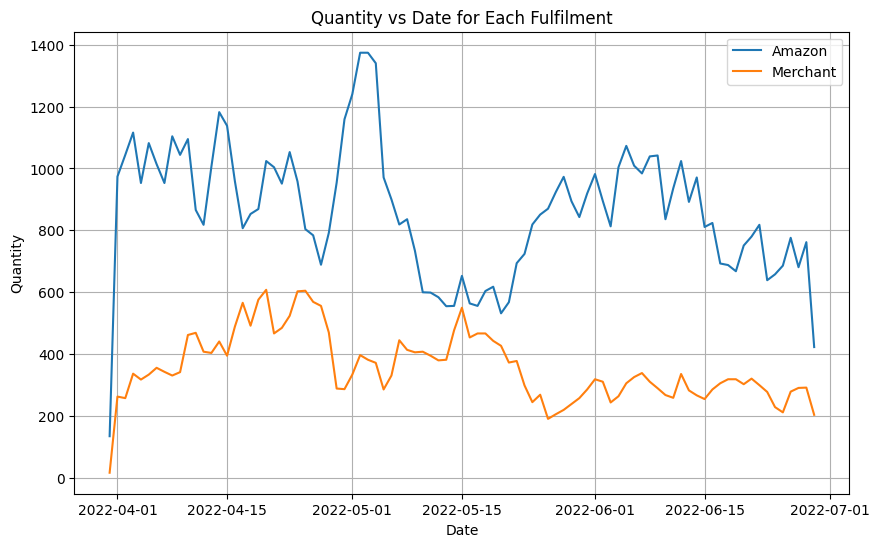

In [61]:
# Create DataFrame
df = pd.DataFrame(group_by_date_fulfilment_df)

# Convert 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'], format='%m-%d-%y')

# Plot line graph for each fulfilment type
plt.figure(figsize=(10, 6))
for fulfilment, group in df.groupby('Fulfilment'):
    plt.plot(group['Date'], group['Qty'], label=fulfilment)

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Quantity')
plt.title('Quantity vs Date for Each Fulfilment')
plt.legend()
plt.grid(True)

# Show plot
plt.show()

In [62]:
# Convert 'Date' column to datetime format
group_by_date_fulfilment_df['Date'] = pd.to_datetime(group_by_date_fulfilment_df['Date'], format='%m-%d-%y')

# Create separate DataFrames for each type of fulfillment
df_amazon = group_by_date_fulfilment_df[group_by_date_fulfilment_df['Fulfilment'] == 'Amazon'].drop(columns=['Fulfilment']).copy()
df_merchant = group_by_date_fulfilment_df[group_by_date_fulfilment_df['Fulfilment'] == 'Merchant'].drop(columns=['Fulfilment']).copy()

# Rename the 'Qty' column to 'sold_qty' and the 'Date' column to 'date'
df_amazon.rename(columns={'Qty': 'sold_qty', 'Date': 'date'}, inplace=True)
df_merchant.rename(columns={'Qty': 'sold_qty', 'Date': 'date'}, inplace=True)

# Print the DataFrames
print("DataFrame for Amazon Fulfilment:")
print(df_amazon.head())
print("\nDataFrame for Merchant Fulfilment:")
print(df_merchant.head())

DataFrame for Amazon Fulfilment:
        date  sold_qty
0 2022-03-31       135
2 2022-04-01       974
4 2022-04-02      1044
6 2022-04-03      1116
8 2022-04-04       953

DataFrame for Merchant Fulfilment:
        date  sold_qty
1 2022-03-31        17
3 2022-04-01       263
5 2022-04-02       258
7 2022-04-03       337
9 2022-04-04       318


### Helper functions

In [63]:

def forecast_sales(data, column_name, forecast_horizon=7, window_size=30):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of days to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=30, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of days to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        order = (5, 1, 0)  # (p, d, q)
        seasonal_order = (1, 1, 1, 12)
        model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
        model_fit = model.fit(disp=False)
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=12)
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test))
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of days to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=1), periods=forecast_horizon, freq='D')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


### Univariant models

#### Amazon

In [64]:
# Example usage
data = df_amazon.copy()

# Call the function
result = forecast_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(result['error_metrics'])

print("Final Forecasts for the next 7 days:")
print(result['forecasts'])

23:23:40 - cmdstanpy - INFO - Chain [1] start processing
23:23:40 - cmdstanpy - INFO - Chain [1] done processing
23:23:44 - cmdstanpy - INFO - Chain [1] start processing
23:23:44 - cmdstanpy - INFO - Chain [1] done processing
23:23:48 - cmdstanpy - INFO - Chain [1] start processing
23:23:49 - cmdstanpy - INFO - Chain [1] done processing
23:23:53 - cmdstanpy - INFO - Chain [1] start processing
23:23:53 - cmdstanpy - INFO - Chain [1] done processing
23:23:57 - cmdstanpy - INFO - Chain [1] start processing
23:23:57 - cmdstanpy - INFO - Chain [1] done processing
23:24:02 - cmdstanpy - INFO - Chain [1] start processing
23:24:02 - cmdstanpy - INFO - Chain [1] done processing
23:24:06 - cmdstanpy - INFO - Chain [1] start processing
23:24:06 - cmdstanpy - INFO - Chain [1] done processing
23:24:10 - cmdstanpy - INFO - Chain [1] start processing
23:24:10 - cmdstanpy - INFO - Chain [1] done processing
23:24:13 - cmdstanpy - INFO - Chain [1] start processing
23:24:14 - cmdstanpy - INFO - Chain [1]

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.132629  0.032210
SARIMA   0.192972  0.058667
ETS      0.131061  0.027983
Prophet  0.220604  0.063251
LSTM     0.160849  0.037622
Final Forecasts for the next 7 days:
            ARIMA  SARIMA  ETS  Prophet  LSTM
Date                                         
2022-06-30    433     359  416      685   701
2022-07-01    376     279  473      725   720
2022-07-02    497     409  500      761   733
2022-07-03    448     414  491      787   747
2022-07-04    515     406  382      727   761
2022-07-05    474     373  337      747   774
2022-07-06    511     460  459      738   788


#### Merchant

In [65]:
# Example usage
data = df_merchant.copy() 

# Call the function
result = forecast_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(result['error_metrics'])

print("Final Forecasts for the next 7 days:")
print(result['forecasts'])

23:27:39 - cmdstanpy - INFO - Chain [1] start processing
23:27:39 - cmdstanpy - INFO - Chain [1] done processing
23:27:43 - cmdstanpy - INFO - Chain [1] start processing
23:27:43 - cmdstanpy - INFO - Chain [1] done processing
23:27:47 - cmdstanpy - INFO - Chain [1] start processing
23:27:47 - cmdstanpy - INFO - Chain [1] done processing
23:27:51 - cmdstanpy - INFO - Chain [1] start processing
23:27:51 - cmdstanpy - INFO - Chain [1] done processing
23:27:56 - cmdstanpy - INFO - Chain [1] start processing
23:27:56 - cmdstanpy - INFO - Chain [1] done processing
23:28:00 - cmdstanpy - INFO - Chain [1] start processing
23:28:00 - cmdstanpy - INFO - Chain [1] done processing
23:28:04 - cmdstanpy - INFO - Chain [1] start processing
23:28:04 - cmdstanpy - INFO - Chain [1] done processing
23:28:08 - cmdstanpy - INFO - Chain [1] start processing
23:28:08 - cmdstanpy - INFO - Chain [1] done processing
23:28:12 - cmdstanpy - INFO - Chain [1] start processing
23:28:12 - cmdstanpy - INFO - Chain [1]

Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.099353  0.017303
SARIMA   0.160658  0.043986
ETS      0.117542  0.022006
Prophet  0.150815  0.032902
LSTM     0.101907  0.019470
Final Forecasts for the next 7 days:
            ARIMA  SARIMA  ETS  Prophet  LSTM
Date                                         
2022-06-30    188     215  226      229   275
2022-07-01    206     250  240      225   283
2022-07-02    209     235  223      249   290
2022-07-03    219     244  227      300   296
2022-07-04    219     230  217      283   303
2022-07-05    214     241  222      282   309
2022-07-06    214     302  269      276   314


### week

In [66]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import LSTM, Dense

def forecast_week_sales(data, column_name, forecast_horizon=7, window_size=7):
    """
    Forecast sales using multiple time series models and calculate error metrics.

    Parameters:
    data (pd.DataFrame): DataFrame containing the sales data.
    column_name (str): Column name of the sales data.
    forecast_horizon (int): Number of weeks to forecast. Default is 7.
    window_size (int): Size of the sliding window for backtesting in weeks. Default is 30.

    Returns:
    dict: Dictionary containing error metrics and forecast values.
    """
    # Convert the date column to datetime if it's not already
    if not pd.api.types.is_datetime64_any_dtype(data['date']):
        data['date'] = pd.to_datetime(data['date'])

    # Aggregate the data into weekly sums
    data.set_index('date', inplace=True)
    data = data.resample('W').sum().reset_index()

    # Normalize the sales data column
    scaler = MinMaxScaler()
    data[column_name] = scaler.fit_transform(data[[column_name]])

    def sliding_window_forecast(data, window_size=7, forecast_horizon=7):
        """
        Generate sliding windows for backtesting.

        Parameters:
        data (pd.DataFrame): DataFrame containing the sales data.
        window_size (int): Size of the sliding window.
        forecast_horizon (int): Number of weeks to forecast.

        Yields:
        tuple: Tuple containing the training and test sets for each window.
        """
        train_size = len(data) - forecast_horizon
        for i in range(train_size - window_size + 1):
            train = data.iloc[i:i + window_size]
            test = data.iloc[i + window_size:i + window_size + forecast_horizon]
            yield train, test

    def calculate_errors(actual, predicted):
        """
        Calculate MAE and MSE error metrics.

        Parameters:
        actual (np.array): Array of actual values.
        predicted (np.array): Array of predicted values.

        Returns:
        tuple: Tuple containing MAE and MSE.
        """
        mae = mean_absolute_error(actual, predicted)
        mse = mean_squared_error(actual, predicted)
        return mae, mse

    def forecast_arima(train, test):
        """
        Forecast using ARIMA model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        model = ARIMA(train[column_name], order=(5, 1, 0))
        model_fit = model.fit()
        forecast = model_fit.forecast(steps=len(test))
        return forecast

    def forecast_sarima(train, test):
        """
        Forecast using SARIMAX model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        try:
            order = (1, 1, 1)  # Simpler (p, d, q)
            seasonal_order = (1, 1, 1, 52)  # Keeping seasonal order same
            model = SARIMAX(train[column_name], order=order, seasonal_order=seasonal_order)
            model_fit = model.fit(disp=False)
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        except np.linalg.LinAlgError:
            print("SARIMAX model fitting failed due to LinAlgError")
            return np.zeros(len(test))

    def forecast_ets(train, test):
        """
        Forecast using ETS model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        seasonal_periods = 4  # Adjusted seasonal periods
        if len(train) >= 2 * seasonal_periods:
            model = ExponentialSmoothing(train[column_name], seasonal='add', seasonal_periods=seasonal_periods)
            model_fit = model.fit()
            forecast = model_fit.forecast(steps=len(test))
            return forecast
        else:
            print("Not enough data for ETS model")
            return np.zeros(len(test))

    def forecast_prophet(train, test):
        """
        Forecast using Prophet model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        train_prophet = train.rename(columns={'date': 'ds', column_name: 'y'})
        model = Prophet()
        model.fit(train_prophet)
        future = model.make_future_dataframe(periods=len(test), freq='W')
        forecast = model.predict(future)
        return forecast['yhat'][-len(test):].values

    def forecast_lstm(train, test):
        """
        Forecast using LSTM model.

        Parameters:
        train (pd.DataFrame): Training set.
        test (pd.DataFrame): Test set.

        Returns:
        np.array: Forecasted values.
        """
        series = train[column_name].values
        if len(series) < 10:
            print("Not enough data for LSTM model")
            return np.zeros(len(test))
        generator = TimeseriesGenerator(series, series, length=10, batch_size=1)
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(10, 1)))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        model.fit(generator, epochs=20, verbose=0)
        test_series = train[column_name].values[-10:]
        forecast = []
        for _ in range(len(test)):
            x_input = test_series[-10:].reshape((1, 10, 1))
            yhat = model.predict(x_input, verbose=0)
            forecast.append(yhat[0][0])
            test_series = np.append(test_series, yhat)
        return np.array(forecast)

    # Initialize dictionaries to store results
    forecast_dict = {}
    error_dict = {}

    # Run backtesting with sliding windows
    for train, test in sliding_window_forecast(data, window_size, forecast_horizon):
        actual = test[column_name].values

        # ARIMA model
        arima_forecast = forecast_arima(train, test)
        mae, mse = calculate_errors(actual, arima_forecast)
        error_dict.setdefault('ARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ARIMA', []).append(arima_forecast)

        # SARIMAX model
        sarima_forecast = forecast_sarima(train, test)
        mae, mse = calculate_errors(actual, sarima_forecast)
        error_dict.setdefault('SARIMA', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('SARIMA', []).append(sarima_forecast)

        # ETS model
        ets_forecast = forecast_ets(train, test)
        mae, mse = calculate_errors(actual, ets_forecast)
        error_dict.setdefault('ETS', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('ETS', []).append(ets_forecast)

        # Prophet model
        prophet_forecast = forecast_prophet(train, test)
        mae, mse = calculate_errors(actual, prophet_forecast)
        error_dict.setdefault('Prophet', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('Prophet', []).append(prophet_forecast)

        # LSTM model
        lstm_forecast = forecast_lstm(train, test)
        mae, mse = calculate_errors(actual, lstm_forecast)
        error_dict.setdefault('LSTM', []).append({'MAE': mae, 'MSE': mse})
        forecast_dict.setdefault('LSTM', []).append(lstm_forecast)

    # Calculate average error metrics for backtesting
    average_error_dict = {model: {'MAE': np.mean([x['MAE'] for x in errors]),
                                  'MSE': np.mean([x['MSE'] for x in errors])}
                          for model, errors in error_dict.items()}

    # Convert error metrics to DataFrame
    error_df = pd.DataFrame(average_error_dict).T
    error_df.index.name = 'Model'
    error_df.columns = ['MAE', 'MSE']

    # Initialize dictionary for final forecasts
    final_forecast_dict = {}

    def final_forecast(model_func, data, forecast_horizon):
        """
        Generate final forecast using the specified model function.

        Parameters:
        model_func (function): Forecast function for the model.
        data (pd.DataFrame): DataFrame containing the sales data.
        forecast_horizon (int): Number of weeks to forecast.

        Returns:
        tuple: Tuple containing forecast dates and values.
        """
        dates = pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')
        forecast = model_func(data, pd.DataFrame(index=dates))
        return dates, forecast

    # ARIMA final forecast
    final_forecast_dict['ARIMA'] = forecast_arima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # SARIMAX final forecast
    final_forecast_dict['SARIMA'] = forecast_sarima(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # ETS final forecast
    final_forecast_dict['ETS'] = forecast_ets(data, pd.DataFrame(index=pd.date_range(start=data['date'].iloc[-1] + pd.Timedelta(days=7), periods=forecast_horizon, freq='W')))

    # Prophet final forecast
    prophet_dates, prophet_forecast = final_forecast(forecast_prophet, data, forecast_horizon)
    final_forecast_dict['Prophet'] = {'dates': prophet_dates, 'forecast': prophet_forecast}

    # LSTM final forecast
    lstm_dates, lstm_forecast = final_forecast(forecast_lstm, data, forecast_horizon)
    final_forecast_dict['LSTM'] = {'dates': lstm_dates, 'forecast': lstm_forecast}

    # Combine forecasts into a DataFrame
    forecast_df = pd.DataFrame(index=prophet_dates)

    # Add forecast values for each model and inverse transform them
    for model in final_forecast_dict:
        forecast_values = final_forecast_dict[model]
        if model in ['Prophet', 'LSTM']:
            forecast_df[model] = scaler.inverse_transform(forecast_values['forecast'].reshape(-1, 1)).flatten().astype(int)
        else:
            forecast_df[model] = scaler.inverse_transform(forecast_values.values.reshape(-1, 1)).flatten().astype(int)

    # Rename the index to 'Date'
    forecast_df.index.name = 'Date'

    # Output object
    result = {
        'error_metrics': error_df,
        'forecasts': forecast_df
    }

    return result


In [67]:
# Load the data
data = df_amazon.copy() 

# Call the function
result = forecast_week_sales(data, 'sold_qty')

# Print the results
print("Backtesting Error Metrics:")
print(result['error_metrics'])

print("Final Forecasts for the next every 7 days:")
print(result['forecasts'])

23:31:33 - cmdstanpy - INFO - Chain [1] start processing


Not enough data for ETS model


23:31:33 - cmdstanpy - INFO - Chain [1] done processing


Not enough data for LSTM model


23:31:33 - cmdstanpy - INFO - Chain [1] start processing
23:31:33 - cmdstanpy - INFO - Chain [1] done processing


Backtesting Error Metrics:
              MAE       MSE
Model                      
ARIMA    0.645625  0.501692
SARIMA   0.279948  0.099636
ETS      0.572845  0.404470
Prophet  0.305498  0.182069
LSTM     0.572845  0.404470
Final Forecasts for the next every 7 days:
            ARIMA  SARIMA   ETS  Prophet  LSTM
Date                                          
2022-07-10   3942    1866  5975     4686  4290
2022-07-17   5273    1866  5464     4564  4201
2022-07-24   6451    1866  5213     4441  4052
2022-07-31   5349    1866  5813     4319  4020
2022-08-07   5792    1866  5975     4196  3989
2022-08-14   3703    1866  5464     4074  3884
2022-08-21   3801    1866  5213     3951  3763


### Multi variant timeseries

In [68]:
grouped_df_3_cols.head()

,Date,Fulfilment,Category,Qty
0,03-31-22,Amazon,Set,60
1,03-31-22,Amazon,Top,8
2,03-31-22,Amazon,Western Dress,2
3,03-31-22,Amazon,kurta,65
4,03-31-22,Merchant,Blouse,1


In [69]:
grouped_df_3_cols.shape

(1262, 4)

In [70]:
# Check for any 0 values in the 'Qty' column
zero_qty = grouped_df_3_cols[grouped_df_3_cols['Qty'] == 0]

# Check for any NaN or Null values in the 'Qty' column
missing_qty = grouped_df_3_cols[grouped_df_3_cols['Qty'].isnull()]

if zero_qty.empty and missing_qty.empty:
    print("There are no 0 values, NaN, or Null values in the 'Qty' column.")
else:
    print("There are some 0 values, NaN, or Null values in the 'Qty' column. Check the data.")


There are no 0 values, NaN, or Null values in the 'Qty' column.


In [71]:
# Create a new column combining product_id and store_id
grouped_df_3_cols['combined_id'] = grouped_df_3_cols['Fulfilment'] + '_' + grouped_df_3_cols['Category']

# Pivot the DataFrame
pivot_df = grouped_df_3_cols.pivot_table(index='Date', columns='combined_id', values='Qty', fill_value=0)

# Reset the index
pivot_df.reset_index(inplace=True)

# Display the modified DataFrame
pivot_df.head()

combined_id,Date,Amazon_Blouse,Amazon_Bottom,Amazon_Dupatta,Amazon_Ethnic Dress,Amazon_Saree,Amazon_Set,Amazon_Top,Amazon_Western Dress,Amazon_kurta,Merchant_Blouse,Merchant_Bottom,Merchant_Ethnic Dress,Merchant_Saree,Merchant_Set,Merchant_Top,Merchant_Western Dress,Merchant_kurta
0,03-31-22,0.0,0.0,0.0,0.0,0.0,60.0,8.0,2.0,65.0,1.0,0.0,0.0,0.0,5.0,1.0,4.0,6.0
1,04-01-22,10.0,1.0,0.0,10.0,0.0,423.0,105.0,50.0,375.0,4.0,1.0,0.0,0.0,97.0,27.0,35.0,99.0
2,04-02-22,5.0,2.0,0.0,4.0,1.0,479.0,102.0,54.0,397.0,0.0,0.0,0.0,0.0,97.0,8.0,39.0,114.0
3,04-03-22,11.0,1.0,0.0,5.0,6.0,536.0,120.0,51.0,386.0,5.0,0.0,2.0,0.0,124.0,24.0,28.0,154.0
4,04-04-22,8.0,2.0,0.0,9.0,0.0,436.0,105.0,49.0,344.0,0.0,1.0,1.0,0.0,123.0,15.0,29.0,149.0


In [72]:
pivot_df.shape

(91, 18)

In [73]:
pivot_df.tail()

combined_id,Date,Amazon_Blouse,Amazon_Bottom,Amazon_Dupatta,Amazon_Ethnic Dress,Amazon_Saree,Amazon_Set,Amazon_Top,Amazon_Western Dress,Amazon_kurta,Merchant_Blouse,Merchant_Bottom,Merchant_Ethnic Dress,Merchant_Saree,Merchant_Set,Merchant_Top,Merchant_Western Dress,Merchant_kurta
86,06-25-22,3.0,6.0,0.0,6.0,1.0,262.0,58.0,108.0,242.0,1.0,1.0,0.0,0.0,104.0,18.0,34.0,54.0
87,06-26-22,1.0,5.0,3.0,7.0,0.0,262.0,74.0,134.0,290.0,1.0,4.0,0.0,0.0,98.0,24.0,54.0,98.0
88,06-27-22,5.0,1.0,0.0,2.0,0.0,269.0,41.0,106.0,257.0,0.0,2.0,2.0,0.0,134.0,19.0,58.0,76.0
89,06-28-22,7.0,3.0,0.0,9.0,2.0,276.0,62.0,88.0,315.0,1.0,2.0,1.0,0.0,110.0,20.0,79.0,79.0
90,06-29-22,3.0,0.0,0.0,4.0,0.0,140.0,38.0,61.0,177.0,0.0,0.0,1.0,0.0,74.0,13.0,45.0,71.0


#### Vector Autoregression (VAR) model

In [74]:
# # Step 1: Prepare the data
# # Assuming your DataFrame is already in the correct format with 'date' as the index and relevant columns
# data = pivot_df.set_index('Date')  # pivot_df 

# # Step 2: Fit VAR model
# model = VAR(data)

# # Choose the order of the VAR model
# order = 1  # Adjust as needed
# results = model.fit(order)

# # Step 3: Forecast future values for the next 7 days
# forecast = results.forecast(data.values[-order:], steps=7)

# # Step 4: Create a DataFrame with forecasted dates and sales values
# last_date = str(data.index[-1])  # Convert the last date to a string
# forecast_dates = pd.date_range(start=last_date, periods=7, freq='D') + pd.Timedelta(days=1)
# forecast_df = pd.DataFrame(forecast.round().astype(int), index=forecast_dates, columns=data.columns)

# # Step 5: Calculate error metrics
# # Get actual values for the forecast period
# actual_values = data.iloc[-7:]

# # Calculate Mean Absolute Error (MAE)
# mae = mean_absolute_error(actual_values, forecast_df)
# # Calculate Mean Squared Error (MSE)
# mse = mean_squared_error(actual_values, forecast_df)

# # Display error metrics
# print("Mean Absolute Error (MAE):", mae)
# print("Mean Squared Error (MSE):", mse)

# # Step 6: Concatenate the original DataFrame with the forecasted DataFrame
# combined_df = pd.concat([data, forecast_df])

# # Display the combined DataFrame with forecasted dates and sales values
# combined_df


In [75]:

# Step 1: Prepare the data
# Assuming your DataFrame is already in the correct format with 'date' as the index and relevant columns
# Here, we use the pivot_df DataFrame and set the 'Date' column as the index
# pivot_df = pd.DataFrame(data)  # Assuming pivot_df is your DataFrame with 'Date' as index
data = pivot_df.set_index('Date')

# Normalize the data
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data)
normalized_data_df = pd.DataFrame(normalized_data, columns=data.columns)

# Fit VAR model
model = VAR(normalized_data_df)
order = 1  # Adjust as needed
results = model.fit(order)

# Forecast future values for the next 7 days
forecast = results.forecast(normalized_data_df.values[-order:], steps=7)

# Inverse transform the forecasted values to the original scale
forecast_inversed = scaler.inverse_transform(forecast)
forecast_inversed_df = pd.DataFrame(forecast_inversed.round().astype(int), columns=data.columns)

# Calculate error metrics with normalized values
# Get actual values for the forecast period
actual_values = normalized_data_df.iloc[-7:]

# Calculate Mean Absolute Error (MAE) with normalized values
mae_normalized = mean_absolute_error(actual_values, forecast)

# Calculate Mean Squared Error (MSE) with normalized values
mse_normalized = mean_squared_error(actual_values, forecast)

# Display error metrics
print("Mean Absolute Error (MAE) with normalized values:", mae_normalized)
print("Mean Squared Error (MSE) with normalized values:", mse_normalized)

# Concatenate the original DataFrame with the forecasted DataFrame
combined_df = pd.concat([data, forecast_inversed_df])

# Display the combined DataFrame with forecasted dates and values
combined_df

Mean Absolute Error (MAE) with normalized values: 0.13601603209611252
Mean Squared Error (MSE) with normalized values: 0.034260390838617025


combined_id,Amazon_Blouse,Amazon_Bottom,Amazon_Dupatta,Amazon_Ethnic Dress,Amazon_Saree,Amazon_Set,Amazon_Top,Amazon_Western Dress,Amazon_kurta,Merchant_Blouse,Merchant_Bottom,Merchant_Ethnic Dress,Merchant_Saree,Merchant_Set,Merchant_Top,Merchant_Western Dress,Merchant_kurta
03-31-22,0.0,0.0,0.0,0.0,0.0,60.0,8.0,2.0,65.0,1.0,0.0,0.0,0.0,5.0,1.0,4.0,6.0
04-01-22,10.0,1.0,0.0,10.0,0.0,423.0,105.0,50.0,375.0,4.0,1.0,0.0,0.0,97.0,27.0,35.0,99.0
04-02-22,5.0,2.0,0.0,4.0,1.0,479.0,102.0,54.0,397.0,0.0,0.0,0.0,0.0,97.0,8.0,39.0,114.0
04-03-22,11.0,1.0,0.0,5.0,6.0,536.0,120.0,51.0,386.0,5.0,0.0,2.0,0.0,124.0,24.0,28.0,154.0
04-04-22,8.0,2.0,0.0,9.0,0.0,436.0,105.0,49.0,344.0,0.0,1.0,1.0,0.0,123.0,15.0,29.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2,7.0,2.0,0.0,9.0,1.0,324.0,81.0,95.0,317.0,1.0,2.0,3.0,0.0,120.0,25.0,68.0,110.0
3,7.0,2.0,0.0,9.0,1.0,325.0,81.0,93.0,325.0,1.0,2.0,3.0,0.0,122.0,24.0,68.0,112.0
4,7.0,2.0,0.0,9.0,1.0,325.0,81.0,92.0,330.0,2.0,2.0,3.0,0.0,123.0,24.0,68.0,114.0
5,7.0,2.0,0.0,9.0,1.0,326.0,80.0,91.0,333.0,2.0,2.0,3.0,0.0,124.0,23.0,68.0,115.0


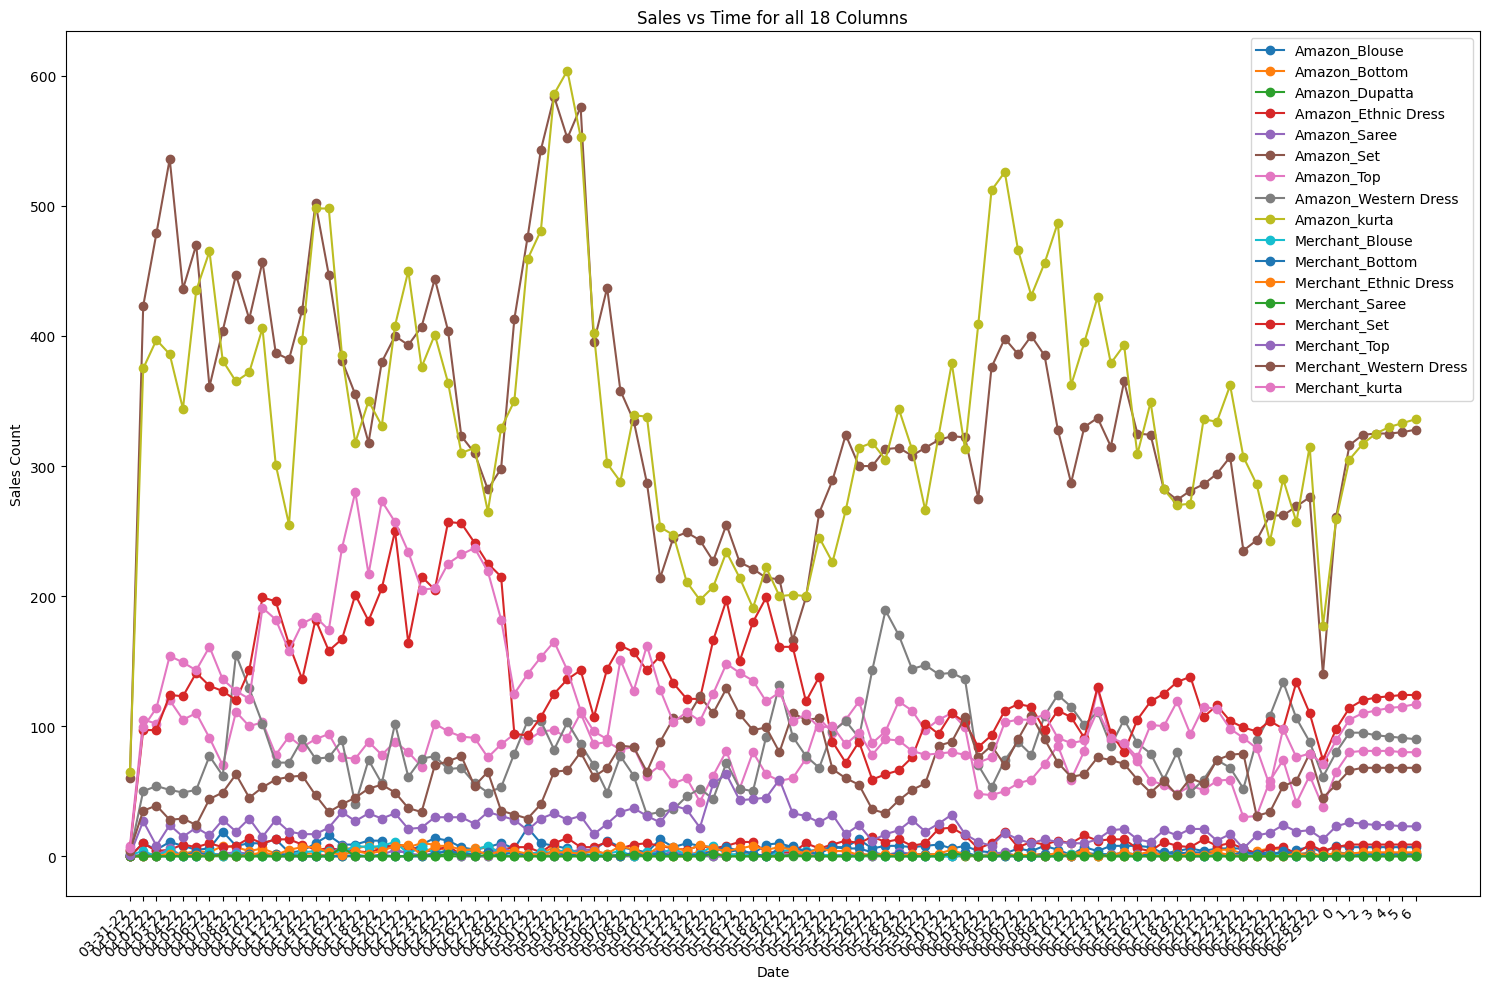

In [76]:
# Convert Timestamp index to string format
combined_df.index = combined_df.index.astype(str)

# Plotting the lines for the first 18 columns
plt.figure(figsize=(15, 10))
for col in combined_df.columns[:18]:  # Selecting the first 18 columns
    plt.plot(combined_df.index, combined_df[col], label=col, marker='o', linestyle='-')

# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Sales Count')
plt.title('Sales vs Time for all 18 Columns')
plt.legend()

# Rotate x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()  # Adjust layout to prevent overlapping

plt.show()